In [19]:
#| echo: false
import os
import datetime as dt

figsize_width = os.getenv("FIGSIZE_WIDTH")
if type(figsize_width) == str:
    figsize_width = int(figsize_width)
else:
    figsize_width = 6

figsize_height = os.getenv("FIGSIZE_HEIGHT")
if type(figsize_height) == str:
    figsize_height = int(figsize_height)
else:
    figsize_height = 4

figsize = (figsize_width, figsize_height)
mpl_style = os.getenv("MPL_STYLE")

if type(mpl_style) != str:
    mpl_style = "pacoty"



::: {.content-visible when-profile="presentation"}
::: {.notes}
### Intro
Hello everyone and welcome to this first video of the Portfolio Geek channel. In this video we will look at what long term investing means for Equity investors.
Many investors think about stock trades and financial analysis, selecting the best stock based on its value, cash flow dividends, and then looking at entry points, trying to find the best timing to exit and so forth. 

Note: ideally, bullet points on green screen to make sure it goes as key holding points.

### Structure of the 10 minutes
What I will aim to do in the next 10 minutes is to provide you with some perspective on why long term investing makes sense, and how it might actually provide very good returns as long as the investor is sufficiently patient about it. 
To do so, I will look at 2 online databases with free access to everyone:
* The first one is a famous one, launched by Robert Shiller, extremely well known in the finance and academic community. It provides everyone with the long term returns of the S&P 500, ie the reference of US Large Cap Equities
* The second one is called the Maddison Project, launched by the university of Maddison in []. It's a fantastic resource for academics as it that compiles what is probably the most comprehensive dataset on historical gdp and gdp per capita across countries. We will dive more into this database in an other video.

### Tools
To put everything together, we will use :
* The python language
* More precisely we will build a Jupyter Notebook, that enables to write, analyse, chart in the same environment
* Several libraries: requests (web request), pandas for data wrangling, scipy for regressions, and matplotlib

But now enough talking, let's go right into it!

 long term Equity return database, and the other is called
:::
:::

::: {.content-visible when-profile="website"}
![](/pictures/time-horizon-paper.png)

## Introduction
Long Term Investing enables investors to capture the long term risk premium of various asset classes.

In this article, we will explore how to download Shiller's Excel data on long-term stock market returns from his website using Python. We will use the requests library for HTTP requests and the pandas library for data manipulation. For visualization, we will use the Matplotlib library with the Pacoty stylesheet to create a chart comparing nominal equity returns, real equity returns, and real GDP growth.

## Downloading Shiller's Data

First, we need to import the required libraries and download the data using an HTTP request:

This code below downloads the Excel file from Shiller's website, directly into memory, and reads it into a pandas DataFrame.
:::

In [1]:
import requests
import pandas as pd
from io import BytesIO
import dataframe_image as dfi

url = "http://www.econ.yale.edu/~shiller/data/ie_data.xls"

response = requests.get(url)

def make_pretty(styler):
    styler.format(precision=2)
    return styler

# Check if the request was successful
if response.status_code == 200:
    data = pd.read_excel(BytesIO(response.content), sheet_name='Data', header=7)
else:
    print("Failed to download the data")

data.iloc[1:10, 1:5].style.pipe(make_pretty)



,P,D,E,CPI
1,4.50,0.26,0.40,12.84
2,4.61,0.26,0.40,13.03
3,4.74,0.26,0.40,12.56
4,4.86,0.26,0.40,12.27
5,4.82,0.26,0.40,12.08
6,4.73,0.26,0.40,12.08
7,4.79,0.26,0.40,11.89
8,4.84,0.26,0.40,12.18
9,4.59,0.26,0.40,12.37


## Downloading Maddison Project GDP Data

In [21]:
url = "https://www.rug.nl/ggdc/historicaldevelopment/maddison/data/mpd2020.xlsx"

response = requests.get(url)

def make_pretty(styler):
    styler.format(precision=2)
    return styler

# Check if the request was successful
if response.status_code == 200:
    data_gdp= pd.read_excel(BytesIO(response.content),sheet_name="Full data", header=0)
else:
    print("Failed to download the data")

In [38]:
import numpy.ma as ma
data_gdp["gdp"] = data_gdp.gdppc * data_gdp["pop"]
dates = ma.array(
    [f'{y}-{12}-{31}' for y in data_gdp.year.to_list()],
    dtype='datetime64[D]'
    )

data_gdp["date"] = dates.tolist()
data_gdp.set_index("date", inplace=True)
data_gdp.iloc[1:10, 1:5].style.pipe(make_pretty)

,country,year,gdppc,pop
date,,,,
1870-12-31,Afghanistan,1870,nan,4207.00
1913-12-31,Afghanistan,1913,nan,5730.00
1950-12-31,Afghanistan,1950,1156.00,8150.00
1951-12-31,Afghanistan,1951,1170.00,8284.00
1952-12-31,Afghanistan,1952,1189.00,8425.00
1953-12-31,Afghanistan,1953,1240.00,8573.00
1954-12-31,Afghanistan,1954,1245.00,8728.00
1955-12-31,Afghanistan,1955,1246.00,8891.00
1956-12-31,Afghanistan,1956,1278.00,9062.00


<AxesSubplot:xlabel='date'>

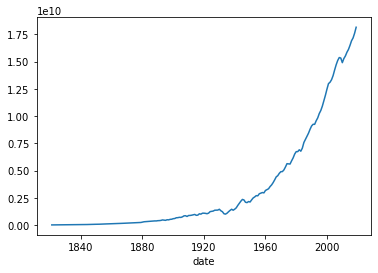

In [39]:
data_gdp[data_gdp.countrycode == "USA"].gdp.plot()

## Cleanup and Columns Renaming

In [4]:
#Excel Import is mixing up columns, re-titling them
data.columns = ["Date", "S&P Composite", "Dividend (D)", "Earnings (E)", "Consumer Price Index (CPI)", "Date Fraction", "Long Interest Rate (I)", "Real Price", "Real Dividend", "Real Total Return Price", "Real Earnings", "Real TR Scaled Earnings", "CAPE", "", "TR CAPE", "", "Excess CAPE Yield", "Monthly Total Bond Returns", "Real Total Bond Returns", "10Y Ann Stock Real Return", "10Y Ann Bon Real Return", "Real 10Y Ann Excess Return"]
data = data[:-2]
data["date"] = pd.to_datetime(data['Date'].map('{:.2f}'.format), format='%Y.%m')
data.set_index("date", inplace=True)
data["Price Return"] = data["Real Price"].div(data["Real Price"].iloc[0])
data["Total Return"] = data.loc[:, "Real Total Return Price"].div(data["Real Total Return Price"].iloc[0])
data["CPI"] = data.loc[:, "Consumer Price Index (CPI)"].div(data["Consumer Price Index (CPI)"].iloc[0])



## Visualizing the Data with Matplotlib and Pacoty

::: {.content-visible when-profile="website"}
Next, we will create a chart comparing the nominal equity returns, real equity returns, and real GDP growth using Matplotlib and the Pacoty.
Let's start with a first sanity check on the data.
:::


![Dataframe](shiller-data.png)


::: {.content-visible when-profile="website"}
This code snippet creates a chart with a logarithmic scale, comparing nominal equity returns, real equity returns, and real GDP growth over time.
:::

## Long Term Equity Returns


KeyError: "None of [Index(['Real Price'], dtype='object')] are in the [columns]"

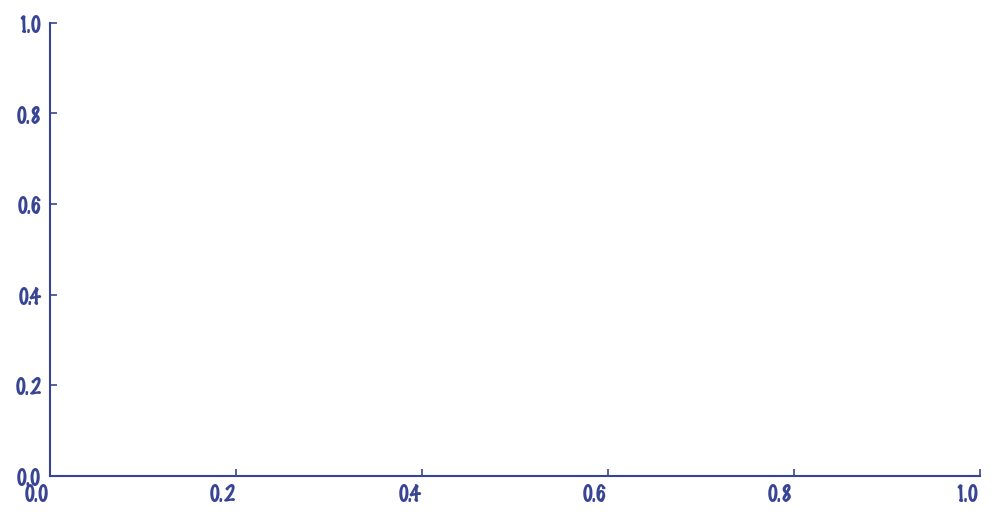

In [40]:
#| label: long-term-return
#| fig-cap: "Long term equity returns vs CPI"
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import highlight_text as ht
from highlight_text import HighlightText, ax_text, fig_text
import matplotlib.dates as mdates
import datetime as dt
from scipy import stats


def decyear4(year, month, day, h=0, m=0, s=0):
    return year + ((30.4375*(month-1) + day-1)*24+h)*3600/31557600.0 

# Set the Pacoty stylesheet
mpl_style = "revealjs_whiteboard"
plt.style.use(f'../../stylesheets/{mpl_style}.mplstyle')

# Create a figure and axis
fig, ax = plt.subplots()
 
# Extract the data we need
dates = data[["Real Price"]].resample("Y").last().index
real_tr = list(data['Price Return'].resample("Y").last().values)
real_pr = list(data["Total Return"].resample("Y").last().values)
cpi = list(data["CPI"].resample("Y").last().values)

#gdp_growth = data['Real GDP Growth']

# Plot the data on a logarithmic scale

f_real_tr= interpolate.interp1d(dates.year, real_tr, 'cubic')
f_real_pr = interpolate.interp1d(dates.year, real_pr, 'cubic')

real_tr_interpol = f_real_tr(dates.year)
real_pr_interpol = f_real_pr(dates.year)

stats.linregress(dates.year, real_tr)

ax.semilogy(dates, real_pr_interpol)
ax.semilogy(dates, real_tr_interpol)
us_gdp = data_gdp[data_gdp.countrycode == "USA"]
ax.semilogy(us_gdp.index, us_gdp)
ax.semilogy(dates, cpi)

#ax.semilogy(years, data[])

size = plt.rcParams['font.size']
highlight_textprops =[{"fontsize": size + 4},
                      {"fontsize": size}]

HighlightText(x=0.5, y=0.98, ha='center', 
              s='<Long Term Equity Returns>\n<Equity vs GDP Growth and Inflation>',
              highlight_textprops=highlight_textprops,
              annotationbbox_kw={'boxcoords': fig.transFigure}, textalign="center")

# Customize the chart
ax.set_xlabel('Years')
ax.set_ylabel(f'Value, basis 1 in {(data.index.min().strftime("%d.%m.%Y"))}')
#ax.set_title('Long Term Equity Returns')
fig.legend(labels = ["US Equity: Price (Real)", "US Equity: Price & Divs (Real)", "CPI"], loc="lower left", ncol=3, bbox_to_anchor=(0.05, -0.03, 0.5, 0.5))
ax.xaxis.set_major_locator(mdates.YearLocator(30))
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Show the chart
plt.show()
plt.close()
#fig.savefig("shiller-returns.png")  

::: {.content-visible when-profile="website"}
The resulting chart demonstrates the power of compounded returns and the equity risk premium that has rewarded long-term shareholders. By using Python libraries like requests, pandas, and Matplotlib, we can easily download, process, and visualize financial data to better understand market trends and investment strategies.
:::

::: {.content-visible when-profile="presentation"}

::: {.notes}
The resulting chart demonstrates the power of compounded returns and the equity risk premium that has rewarded long-term shareholders. By using Python libraries like requests, pandas, and Matplotlib, we can easily download, process, and visualize financial data to better understand market trends and investment strategies.
:::

:::